# Custom Logistic Regression
## 1) A custom multi-linear binary logistic regression

#### Importing libraries

In [99]:
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-darkgrid')
# plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Importing data

In [100]:
X_feat, y_target = [], []
with open('data/ex2data1.mat') as data:
    for line in data:
        line = line.strip().split(',')
        X_feat.append([1.0,float(line[0]),float(line[1])]) # 1 adds the bias term or the feature x0 which is always 1
        y_target.append([float(line[2])])
X_feat, y_target = np.array(X_feat), np.array(y_target)
X_feat.shape, y_target.shape

((100, 3), (100, 1))

#### Visualizing the dataset

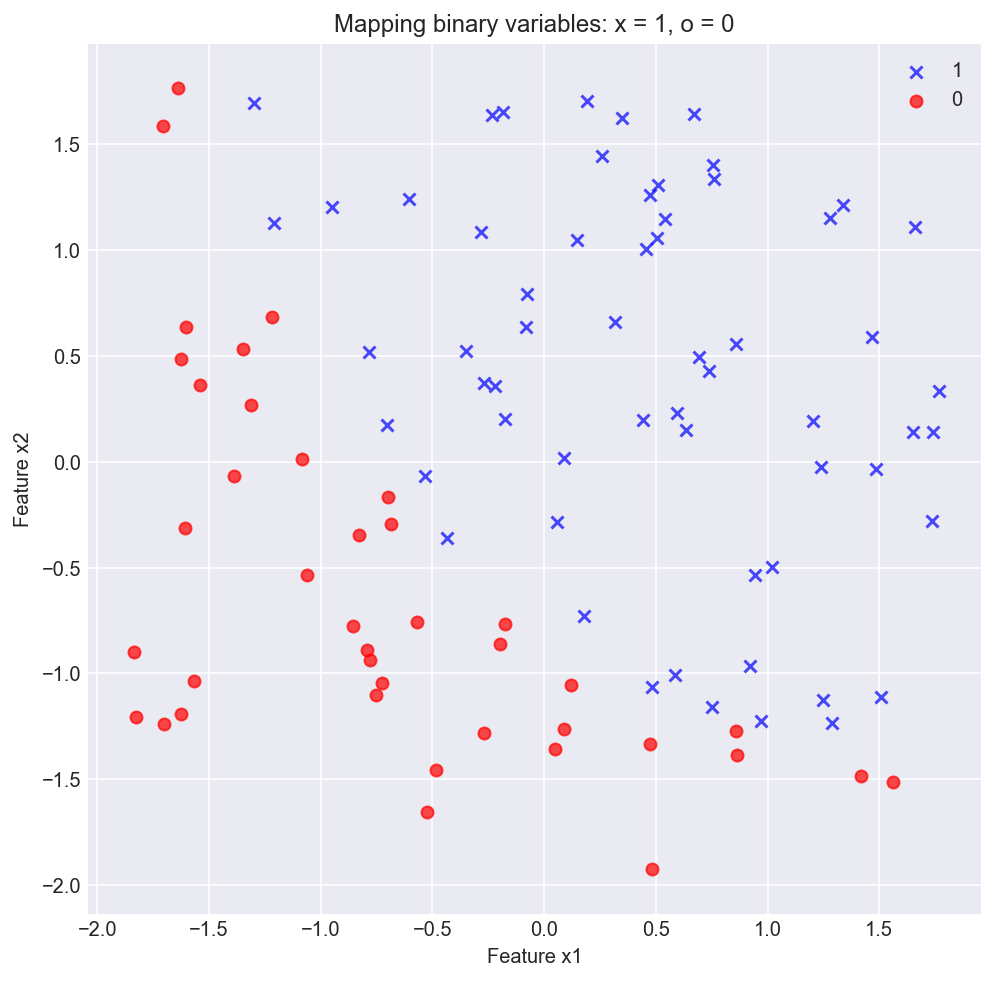

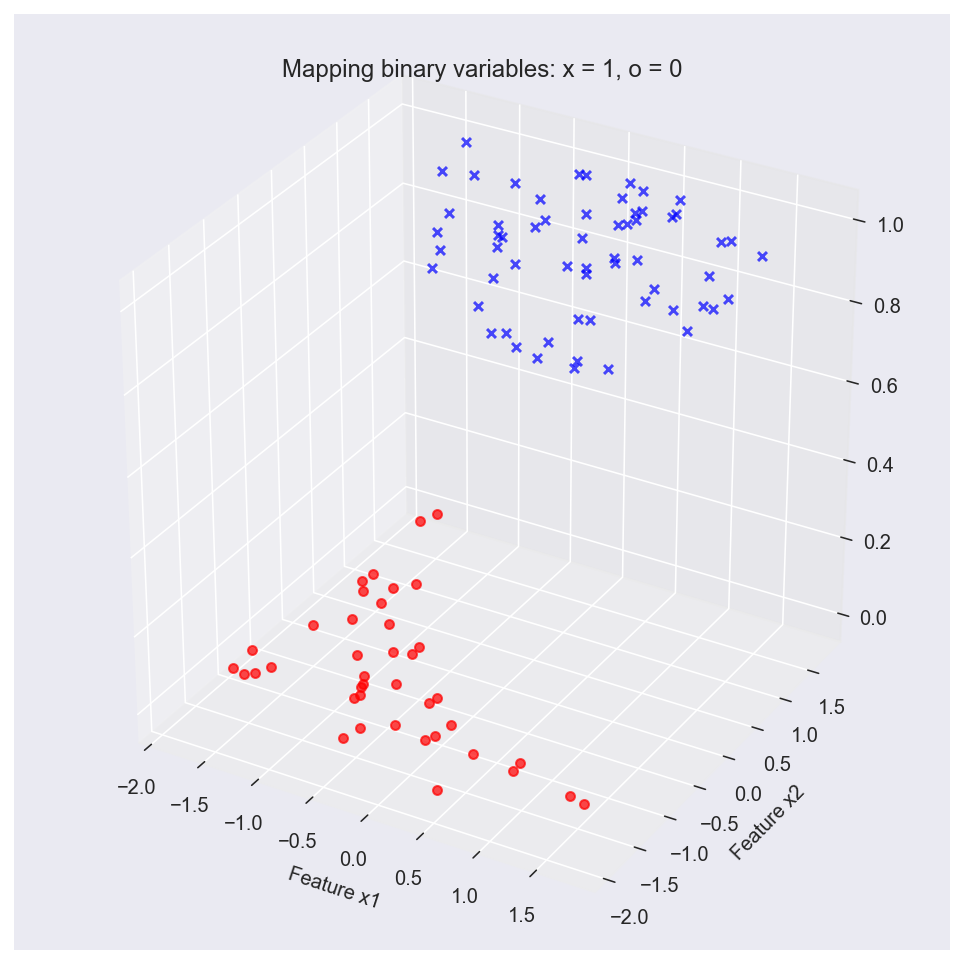

In [107]:
# 2D plot of the data
def plot_scatter(X, y):
    z_true, z_false = [], []
    # Create two sets of nx2 size arrays to hold the true(1) and false(0) points
    for i in range(y.size):
        if y[i]:
            z_true.append([X[i,1], X[i,2]])
        else:
            z_false.append([X[i,1], X[i,2]])
    z_true, z_false = np.array(z_true), np.array(z_false)
    plt.scatter(x=z_true[:,0], y=z_true[:,1], alpha=0.7, c='blue', marker='x', label='1')
    plt.scatter(x=z_false[:,0], y=z_false[:,1], alpha=0.7, c='red', marker='o', label='0')
    plt.legend(loc='upper right')
    plt.title("Mapping binary variables: x = 1, o = 0")
    plt.xlabel("Feature x1")
    plt.ylabel("Feature x2")

# 3D plot of the data
def plot_scatter_3D(X, y):
    fig = plt.figure(figsize=[6.5,6.5])
    ax = Axes3D(fig)
    cmap = [ 'b' if c else 'r' for c in y]
    mmap = [ 'x' if c else 'o' for c in y]
    for i in range(y.size):
        ax.scatter(X[i,1], X[i,2], y[i,0], alpha=0.7, c=cmap[i], marker=mmap[i])
    plt.title("Mapping binary variables: x = 1, o = 0")
    plt.xlabel("Feature x1")
    plt.ylabel("Feature x2")

plt.figure(figsize=[8, 8])
plot_scatter(X_feat, y_target)
plot_scatter_3D(X_feat, y_target)
plt.show()

#### Creating Model with utility functions

##### Hypothesis function
$ 
h_\theta(x) = g(x) = g(\theta^TX) = g(\theta X) \\
z =\theta^TX = \theta_0 + \theta_1x_1 + \theta_2x_2, \>\> (x_0=1) \\
g(z) = \frac{1}{1+e^{-z}} 
$

In [102]:
def sigmoid(z):
    '''Sigmoid / logistic function'''
    return 1/(1+np.exp(-z))

def y_pred(X_feat, theta_vector):
    '''Hypothesis func that uses the sigmoid function'''
    z = X_feat.dot(theta_vector)
    return sigmoid(z)

def mean_norm(X_feat):
    '''Function to mean normalize our data
    Important Note: Do not normalize the x0 feature which is always one'''
    np_mean, np_std = np.mean(X_feat[:,1:], axis=0), np.std(X_feat[:,1:], axis=0)
    X_feat[:,1:] -= np_mean
    X_feat[:,1:] /= np_std
    return X_feat

##### Loss/cost function

$
Cost(x,y)=\begin{cases}
    -\log{(h_\theta(x))}, & \text{if $y=1$}.\\
    -\log{(1-h_\theta(x))}, & \text{if $y=0$}.
  \end{cases}$

$ J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)}\log{( h_\theta(x^{(i)}))} + (1-y^{(i)}) \log{(1-h_\theta(x^{(i)})} ]  \\
 J(\theta) = -\frac{1}{m} [ y^T(\log{( h_\theta(x^{(i)}))}) + (1-y)^T(\log{( 1-  h_\theta(x^{(i)}))}) ] 
$

In [103]:
def logistic_loss(X_feat, y_target, theta_vector):
    ''' Vectorized implementation of the loss function'''
    y_predicted = y_pred(X_feat, theta_vector)    
    return (-1/y_target.size) * ((np.transpose(y_target)).dot(np.log(y_predicted)) + (np.transpose(1-y_target)).dot( np.log(1-y_predicted)) )

def plot_loss_curve(loss, epochs, log=True):
    '''Note: plt.show() is not called by default in this function'''
    loss = [np.asscalar(i) for i in loss]
    if log:
        plt.semilogx(range(epochs), loss)
    else:
        plt.plot(loss)
    plt.title("Loss overtime")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.grid(True)
    
def plot_boundary_line(theta_vector, X_feat, y_target): 
    # Here x = feature x1 and y = feature x2
    x_min, x_max, y_min, y_max = min(X_feat[:,1])-0.5, max(X_feat[:,1])+0.5, min(X_feat[:,2])-0.5, max(X_feat[:,2])+0.5 # find min,max of both x and y axis values
    
    x0, y0 = np.linspace(x_min, x_max, num=100), np.linspace(y_min, y_max, num=100) # gen evenly spaced 100 points between min, max values in the x and y axis
    xx, yy = np.meshgrid(x0, y0)
    ''' 
    np.ones((xx.ravel().shape[0],1)) generates a [(ravelled xx numpy arr len), 1] array which is concatenated with the np.c_[] to the ravelled xx and yy arrays
    Straightens the xx and yy arrays then concatenate them on axis=1 or rowise, X_all.shape = [xx.size * yy.size, 3]
    '''
    X_all = np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()]  # for just the linear logistic regression part    
    if theta_vector.size == 6: # 2nd degree polynomial logistic regression
        # engineering the new polynomial features in the form 1, a, b, a^2, b^2 and ab
        eng_feat1 = np.array(X_all[:,1:3]**2) # a^2 and b^2
        eng_feat2 = np.array(X_all[:,1]* X_all[:,2]).reshape(X_all.shape[0], 1) # ab
        X_all = np.c_[X_all, eng_feat1, eng_feat2] # np.concatenate((X_feat, eng_feat1, eng_feat2), axis=1)

    X_all_pred = y_pred(X_all, theta_vector)
    X_all_pred = np.array([1 if i >= 0.5 else 0 for i in X_all_pred])
    X_all_pred = X_all_pred.reshape(xx.shape)
    
    # plot the contours
    plt.contourf(xx, yy, X_all_pred, cmap=mpl.colors.ListedColormap(['#cc9880', '#7e97cc']) )

    plot_scatter(X_feat, y_target)
    plt.legend(loc='upper right')
    plt.title("Mapping binary variables")
    plt.xlabel("Feature x1")
    plt.ylabel("Feature x2")
    plt.grid(True)


##### Gradient Descent update
$ 
\theta := \theta  - \frac{\alpha}{m} \sum_{i=1}^{m} [(h_\theta(x^{(i)}) - y^{(i)}).x^{(i)}] \\
\theta := \theta - \frac{\alpha}{m} X^T(g(X\theta)-\vec{y}) 
$

In [104]:
class logistic_regression:
    def __init__(self, alpha, epochs):
        self.theta_vector = np.zeros(3)
        self.theta_vector = self.theta_vector.reshape((3,1))
        self.alpha = alpha
        self.epochs = epochs
        self.loss = []
    
    def train(self, X_feat, y_target):
        for epoch in range(self.epochs):
            self.theta_vector -= ((self.alpha/y_target.size) * ((np.transpose(X_feat)).dot( y_pred(X_feat, self.theta_vector) - y_target)) ) 
            self.loss.append(logistic_loss(X_feat, y_target, self.theta_vector))

#### Training our model

In [105]:
X_feat = mean_norm(X_feat)
lo1 = logistic_regression(0.0010, 50000)
lo1.train(X_feat, y_target)

#### Comparing our model

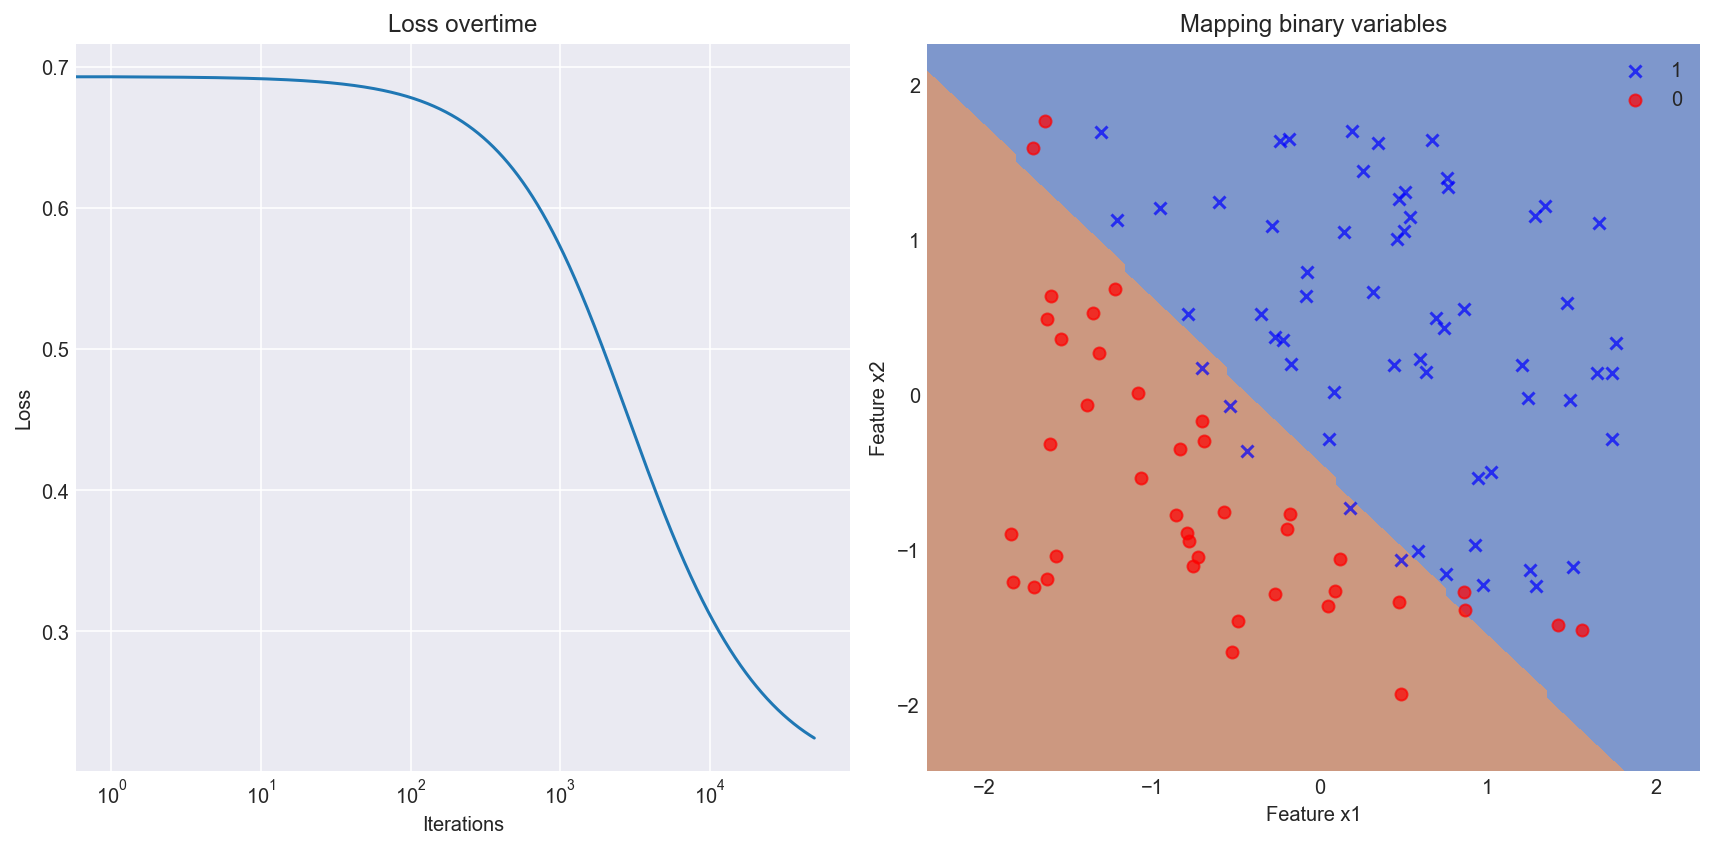

In [108]:
def plot_loss_and_fit(X_feat, y_target, logistic_model):
    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plot_loss_curve(logistic_model.loss, logistic_model.epochs)
    plt.subplot(1,2,2)
    plot_boundary_line(logistic_model.theta_vector, X_feat, y_target)
    plt.tight_layout()
    plt.show()
    
plot_loss_and_fit(X_feat, y_target, lo1)

In [81]:
def logistic_accuracy(predicted_labels, actual_labels):
    ''' function to calculate the accuracy of my model'''
    count = 0
    for i in range(len(actual_labels)):
        if predicted_labels[i] == actual_labels[i]:
            count += 1
    return count/(len(actual_labels))

In [82]:
# Accuracy on our test data
pred = y_pred(X_feat, lo1.theta_vector)
pred = [1 if x >= .5 else 0 for x in pred]
lo1_parameters = lo1.theta_vector.reshape(1,3)
print(f"Parameterx for the custom linear logistic model = {lo1_parameters}, loss = {np.asscalar(lo1.loss[-1])}, accuracy = {logistic_accuracy(pred, y_target)}")

Parameterx for the custom linear logistic model = [[1.00383155 2.49042443 2.27694668]], loss = 0.2244701492763577, accuracy = 0.89


#### Comparing with a scikit-learn logistic regression model 
The scikit learn implementation has different parameters because it implements regularization of the model to prevent overfitting

In [83]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 

model = LogisticRegression(solver='lbfgs')
y_target = np.ravel(y_target)
model.fit(X_feat, y_target)
predicted_classes = model.predict(X_feat)
accuracy = accuracy_score(y_target.flatten(),predicted_classes)
parameters = model.coef_

In [84]:
print(f"The parameter for the scikit logistic model is {parameters}, and the accuracy is {accuracy}")

The parameter for the scikit logistic model is [[-3.89764541e-05  2.28480941e+00  2.09157363e+00]], and the accuracy is 0.89


## 2) Improved custom polynomial binary logistic regression
Our initial linear logistic model has a pretty high accuracy however it does not fully fit our data points if we observe the plotted data. So, we will train a new polynomial based logistic regression of the second degree.

New polynomial hypothesis function. New features engineered from from the original $x_1$ and $x_2$ features.

$ h_\theta(x) = g(\theta^TX) = g(X\theta) \\
z = X\theta = \theta_0 + \theta_1(x_1) + \theta_2(x_2) + \theta_3(x_1)^2 + \theta_4(x_2)^2, (x_0 = 1) \\
g(z) = \frac{1}{1+e^{-z}} \\
$

#### Cost function
$ Cost(x,y)=\begin{cases}
    -\log{(h_\theta(x))}, & \text{if $y=1$}.\\
    -\log{(1-h_\theta(x))}, & \text{if $y=0$}.
  \end{cases} \\
  J(\theta)= -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)}(\log{(h_\theta(x^{(i)}))}) + (1-y^{(i)}) ( \log{(1-h_\theta(x^{(i)}))} ) ] \\
  h = h_\theta(X\theta) \\
  J(\theta)= -\frac{1}{m} [ ( y^T(\log{(h)}) ) + (1-y)^T(\log{(1-h)}) ] \\ $

#### Gradient Descent update
$ \theta := \theta - \frac{\alpha}{m} \sum^{m}_{i=1} [(h_\theta(x^{(i)} - y^{(i)}) ).x^{(i)}]  \\
\theta := \theta - \frac{\alpha}{m} X^T(h_\theta(X\theta) - \vec{y}) $

In [133]:
class polynomial_logistic_regression:
    def __init__(self, epochs, alpha):
        self.theta_vector = (np.zeros(6)).reshape(6,1) # parameters/weights for the model
        self.epochs = epochs
        self.alpha = alpha
        self.loss = []
    
    def train(self, X_feat, y_target):
        for epoch in range(self.epochs):
            self.theta_vector -= ((self.alpha/y_target.size) * ((np.transpose(X_feat)).dot( y_pred(X_feat, self.theta_vector) - y_target.reshape(X_feat.shape[0],1) )) ) 
            self.loss.append(logistic_loss(X_feat, y_target, self.theta_vector))

# engineering the new polynomial features in the form 1, a, b, a^2, b^2 and ab
eng_xf1_feat1 = np.array(X_feat[:,1:3]**2) # a^2 and b^2
eng_xf1_feat2 = (X_feat[:,1]* X_feat[:,2]).reshape(100,1) # ab
X_eng_feat = np.c_[X_feat, eng_xf1_feat1, eng_xf1_feat2] # np.concatenate((X_feat, eng_feat1, eng_feat2), axis=1)

In [94]:
plo1 = polynomial_logistic_regression(50000, 0.010)
plo1.train(X_eng_feat, y_target)

In [95]:
# Accuracy on our test data
pred = y_pred(X_eng_feat, plo1.theta_vector)
pred = [1 if x >= .5 else 0 for x in pred]
plo1_parameters = plo1.theta_vector.reshape(1,6)
print(f"Parameterx for the custom polynomial logistic model = {plo1_parameters}, loss = {np.asscalar(plo1.loss[-1])}, accuracy = {logistic_accuracy(pred, y_target)}")

Parameterx for the custom polynomial logistic model = [[ 5.32052321  5.31924715  5.34248047 -2.44900503 -1.69566461 -1.30712068]], loss = 0.07970447136514609, accuracy = 1.0


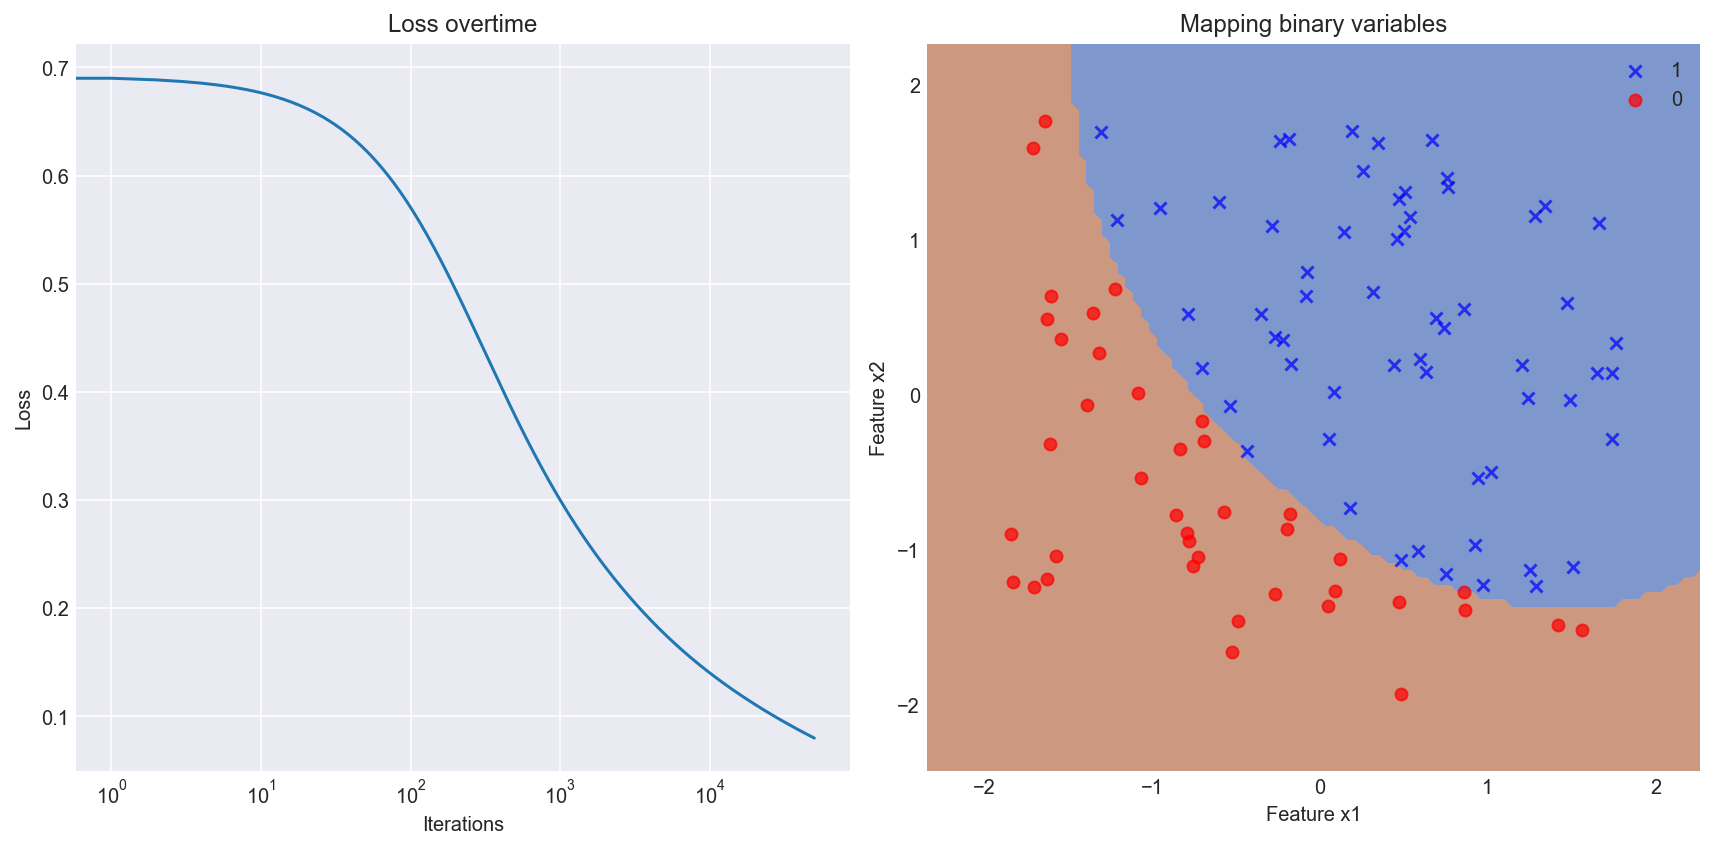

In [109]:
plot_loss_and_fit(X_feat, y_target, plo1)

## Polynomial Logistic Regression on another dataset (Without regularization)

### Importing data

In [120]:
X_feat2, y_target2 = [], []
with open('data/ex2data2.mat') as data2:
    for line in data2:
        line = line.strip().split(',')
        X_feat2.append([1.0, float(line[0]), float(line[1])]) # 1 adds the bias term or the feature x0 which is always 1
        y_target2.append([float(line[2])])
X_feat2, y_target2 = np.array(X_feat2), np.array(y_target2)       
X_feat2.shape, y_target2.shape

((118, 3), (118, 1))

### Visualizing the dataset

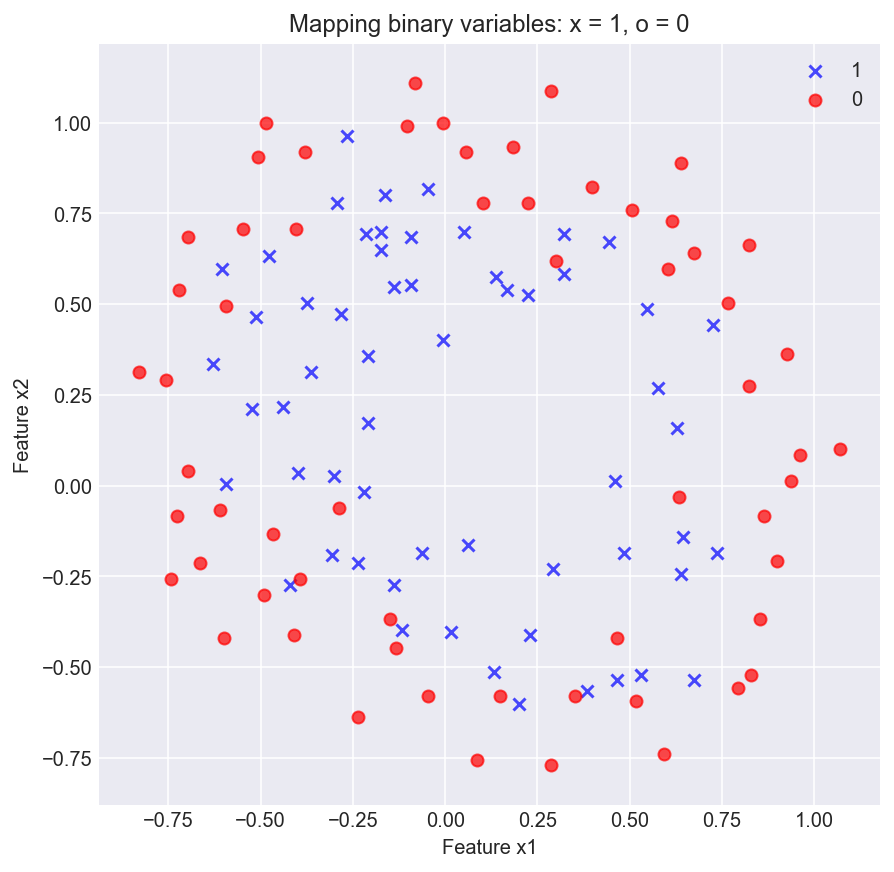

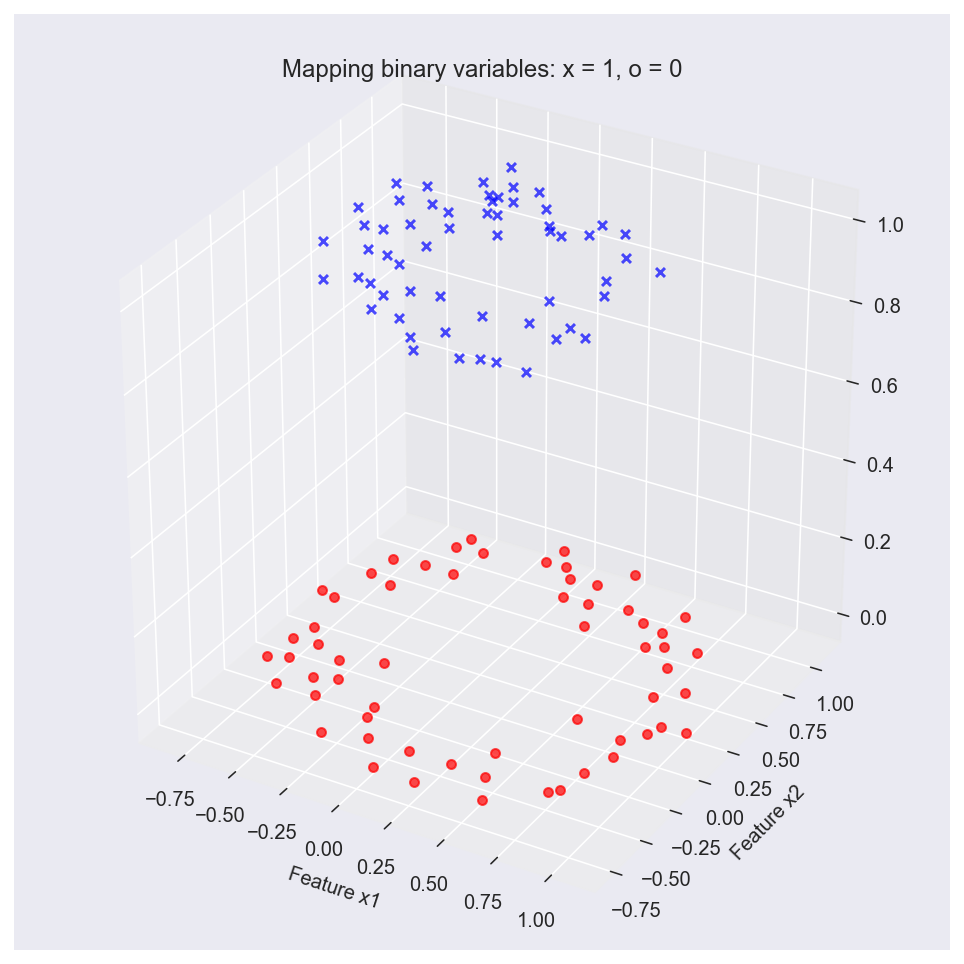

In [121]:
plt.figure(figsize=[7,7])
plot_scatter(X_feat2, y_target2)
plot_scatter_3D(X_feat2, y_target2)
plt.show()

### Engineering polynomial features and training our polynomial logistic regression model


In [131]:
# features a^2 and b^2 given feat X_feat[1, a, b] where a=x1 and b=x2
eng_xf2_feat1 = X_feat2[:,1:]**2 # a^2, b^2
eng_xf2_feat2 = (X_feat2[:,1]*X_feat2[:,2]).reshape(X_feat2.shape[0], 1) # ab
X_eng_feat2 = np.c_[X_feat2, eng_xf2_feat1, eng_xf2_feat2]
X_eng_feat2.shape

(118, 6)

In [144]:
# Train our polynomial logistic regression model
plo2 = polynomial_logistic_regression(100000, 0.012)
plo2.train(X_eng_feat2, y_target2)

In [145]:
# Accuracy on our test data
pred = y_pred(X_eng_feat2, plo2.theta_vector)
pred = [1 if x >= .5 else 0 for x in pred]
plo2_parameters = plo2.theta_vector.reshape(1,6)
print(f"Parameterx for the custom polynomial logistic model = {plo2_parameters}, loss = {np.asscalar(plo2.loss[-1])}, accuracy = {logistic_accuracy(pred, y_target2)}")

Parameterx for the custom polynomial logistic model = [[ 4.06971678  2.38876439  3.14194163 -9.44783229 -9.10789342 -5.41970663]], loss = 0.35638496144709964, accuracy = 0.847457627118644


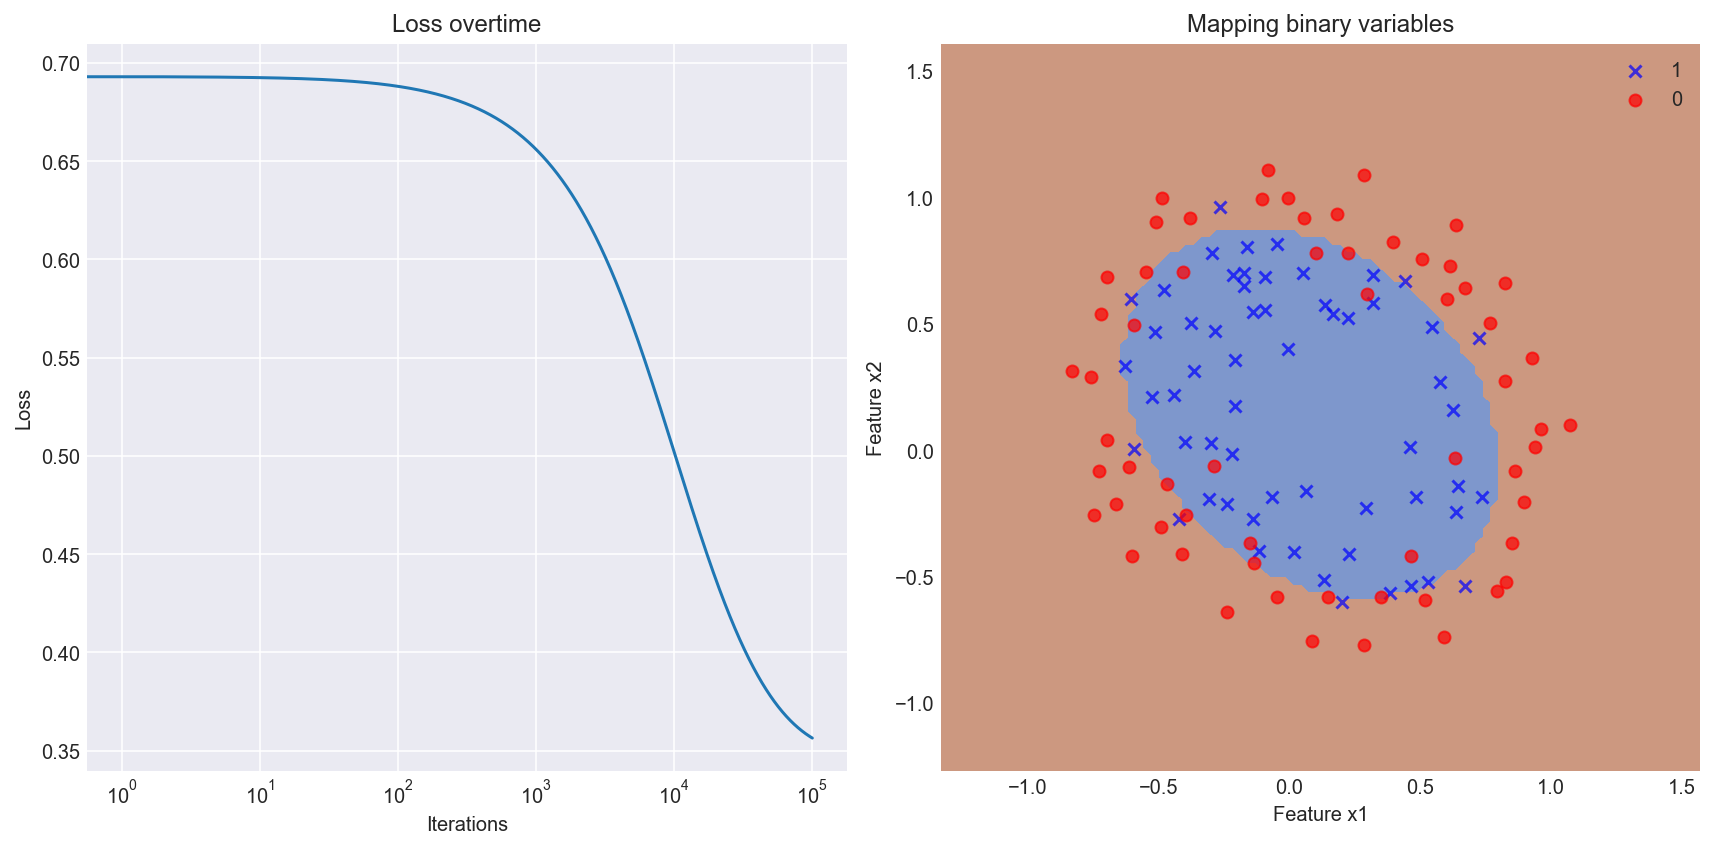

In [146]:
plot_loss_and_fit(X_feat2, y_target2, plo2)

## Regularized Polynomial Logistic Regression (With regularization)
Now we implment an improved version of our logistic regression algorithm with regularization to prevent overfitting on training data.